In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### **Many-Shocks Bartik IV with Energy and Import Exposure**

We construct a Bartik-style instrument that averages a country’s exposure to two types of price shocks: **energy** and **import** prices. Each component contributes equally (weight of ½).

#### **1. Bartik IV Definition**

Let:

- \( s^{\text{energy}}_{ik} \): share of energy product \( k \) in country \( i \)’s energy consumption  
- \( s^{\text{import}}_{ij} \): share of imported product \( j \) in country \( i \)’s total imports  
- \( p^{\text{energy}}_k \): price shock to energy product \( k \)  
- \( p^{\text{import}}_j \): price shock to import product \( j \)

Then the Bartik instrument for country \( i \) is:

$$
\text{Bartik}_i = \frac{1}{2} \sum_k s^{\text{energy}}_{ik} \cdot p^{\text{energy}}_k + \frac{1}{2} \sum_j s^{\text{import}}_{ij} \cdot p^{\text{import}}_j
$$

---

#### **2. Share Matrix Formulation**

We can express this as a weighted sum over a combined product index \( \ell \), where \( \ell \) indexes both energy and import products:

$$
S_{i\ell} =
\begin{cases}
\frac{1}{2} s^{\text{energy}}_{ik} & \text{if } \ell \text{ corresponds to energy product } k \\\\
\frac{1}{2} s^{\text{import}}_{ij} & \text{if } \ell \text{ corresponds to import product } j
\end{cases}
$$

So the overall instrument becomes:

$$
\text{Bartik}_i = \sum_\ell S_{i\ell} \cdot p_\ell
$$

where:

- \( S \) is the **exposure matrix** (countries \( i \) × products \( \ell \))  
- \( p_\ell \) are the **exogenous shocks** (e.g., world price changes)



In [13]:
# Combine both series into a single normalized vector (they already sum to 1 each)
# So we'll concatenate and then renormalize

# Energy shares
energy_shares = pd.Series({
    "oil_consumption": 0.381066,
    "gas_consumption": 0.225697,
    "coal_consumption": 0.174941,
    "hydro_consumption": 0.088659,
    "nuclear_consumption": 0.055092,
    "wind_consumption": 0.030536,
    "other_renewable_consumption": 0.024421,
    "solar_consumption": 0.010104,
    "biofuel_consumption": 0.009483
})

# Import shares
import_shares = pd.Series({
    271111: 0.094092,
    7601: 0.092204,
    4407: 0.082425,
    7108: 0.054488,
    2601: 0.048609,
    2701: 0.043858,
    1005: 0.039965,
    207: 0.037953,
    9012100: 0.034764,
    201: 0.033852,
    7403: 0.031546,
    4403: 0.031135,
    1001: 0.029407,
    803: 0.022129,
    4412: 0.020991,
    7110: 0.019684,
    9011100: 0.019216,
    1701: 0.019139,
    4001: 0.019035,
    306: 0.018706,
    310210: 0.018639,
    1511: 0.017552,
    1514: 0.015926,
    1201: 0.014924,
    2401: 0.013165,
    7901: 0.012966,
    1003: 0.010945,
    1006: 0.009979,
    7502: 0.009678,
    7801: 0.008848,
    80510: 0.008179,
    180100: 0.007975,
    15121990: 0.007719,
    1507: 0.007219,
    7106: 0.006549,
    310420: 0.005935,
    204: 0.005663,
    2510: 0.005381,
    310530: 0.004884,
    8001: 0.004392,
    23012000: 0.003022,
    12024200: 0.002881,
    5201: 0.001170,
    9024000: 0.001112,
    15131999: 0.001043,
    9021000: 0.000896,
    1007: 0.000161
})

# Combine and normalize
combined_shares = pd.concat([energy_shares, import_shares])
combined_shares /= combined_shares.sum()

# Compute Herfindahl index
herfindahl_index = (combined_shares ** 2).sum()

# Compute effective number of shocks
effective_shocks = 1 / herfindahl_index

print(
    f"Herfindahl index: {herfindahl_index:.2f}\n"
    f"Effective number of shocks: {effective_shocks:.0f}"
)

Herfindahl index: 0.07
Effective number of shocks: 14


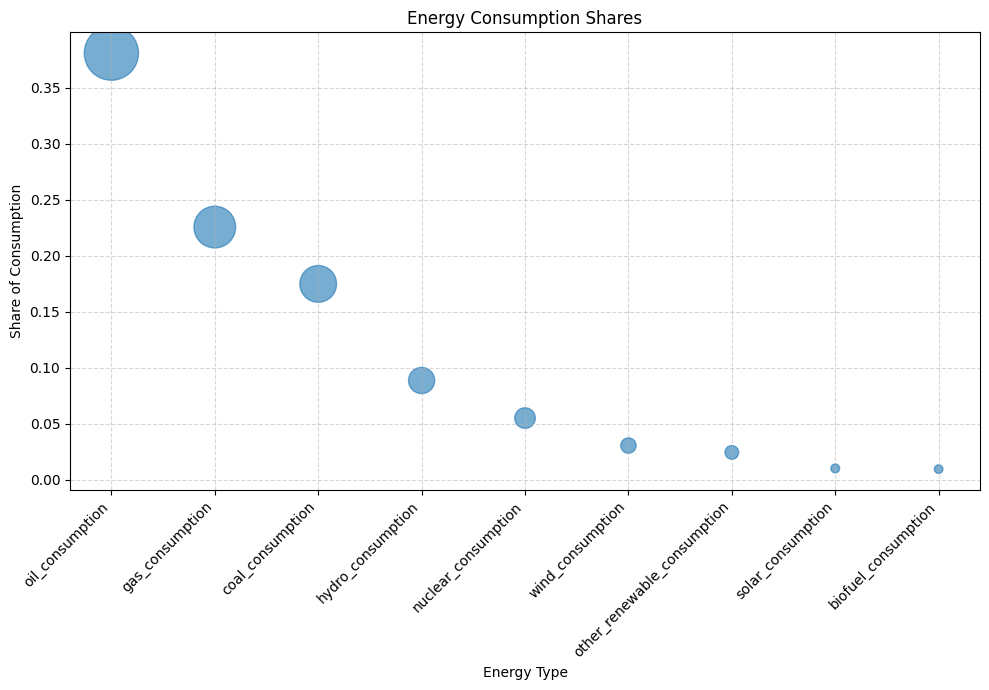

In [3]:
# Sort for plotting
energy_shares = energy_shares.sort_values(ascending=False)

# Create a bubble chart
plt.figure(figsize=(10, 7))
plt.scatter(x=range(len(energy_shares)), y=energy_shares.values, s=energy_shares.values * 4000, alpha=0.6)
plt.xticks(range(len(energy_shares)), energy_shares.index, rotation=45, ha='right')
plt.xlabel("Energy Type")
plt.ylabel("Share of Consumption")
plt.title("Energy Consumption Shares")

plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

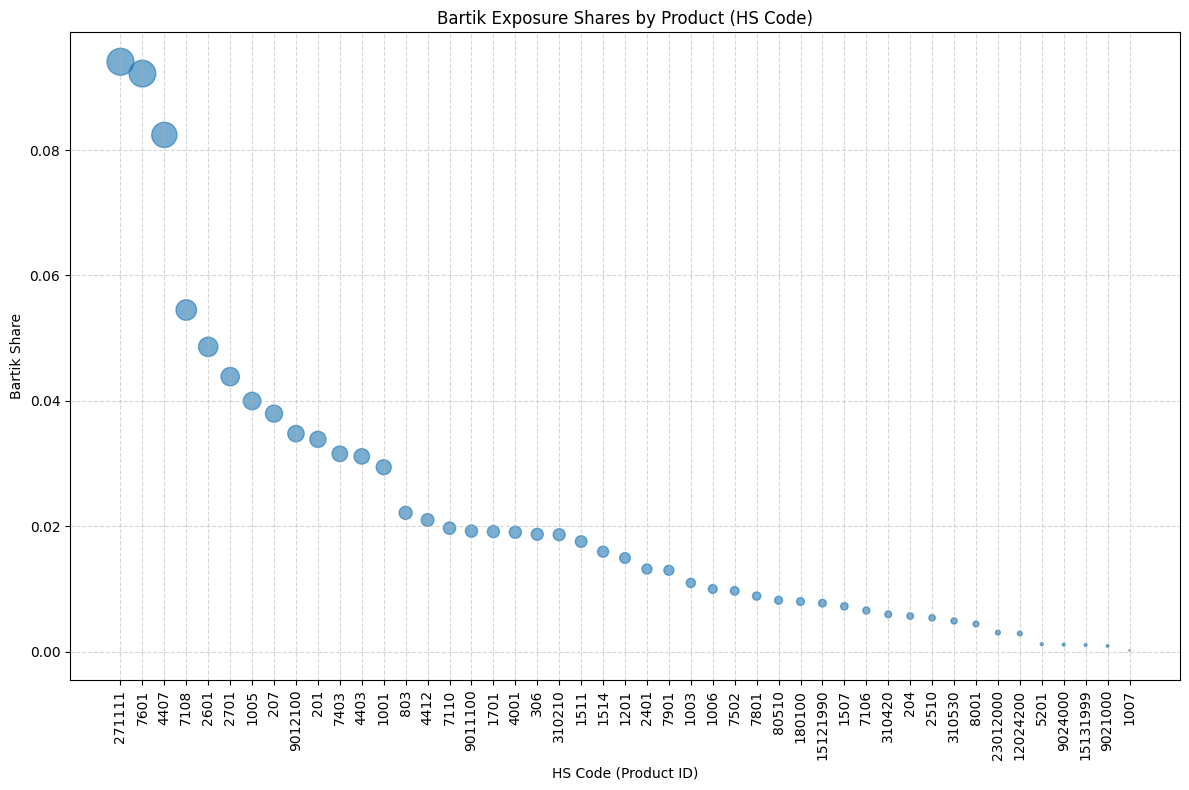

In [4]:
# Sort and prepare for plotting
bartik_shares = import_shares.sort_values(ascending=False)

# Create a bubble chart
plt.figure(figsize=(12, 8))
plt.scatter(x=range(len(bartik_shares)), y=bartik_shares.values, s=bartik_shares.values * 4000, alpha=0.6)
plt.xticks(range(len(bartik_shares)), bartik_shares.index.astype(str), rotation=90)
plt.xlabel("HS Code (Product ID)")
plt.ylabel("Bartik Share")
plt.title("Bartik Exposure Shares by Product (HS Code)")

plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [5]:
bartik_energy = pd.read_csv('../Design/data/bartik_iv.csv')
bartik_imports = pd.read_csv('data/bartik_iv.csv')

In [6]:
# sum bartik energy and imports
bartik = bartik_energy.merge(bartik_imports, on='country', how='outer').replace(np.nan, 0)

In [7]:
bartik['final'] = bartik['bartik_iv_x'] * 100 + bartik['bartik_iv_y']
bartik = bartik[['country','final']].rename(columns={'final': 'bartik_iv'})

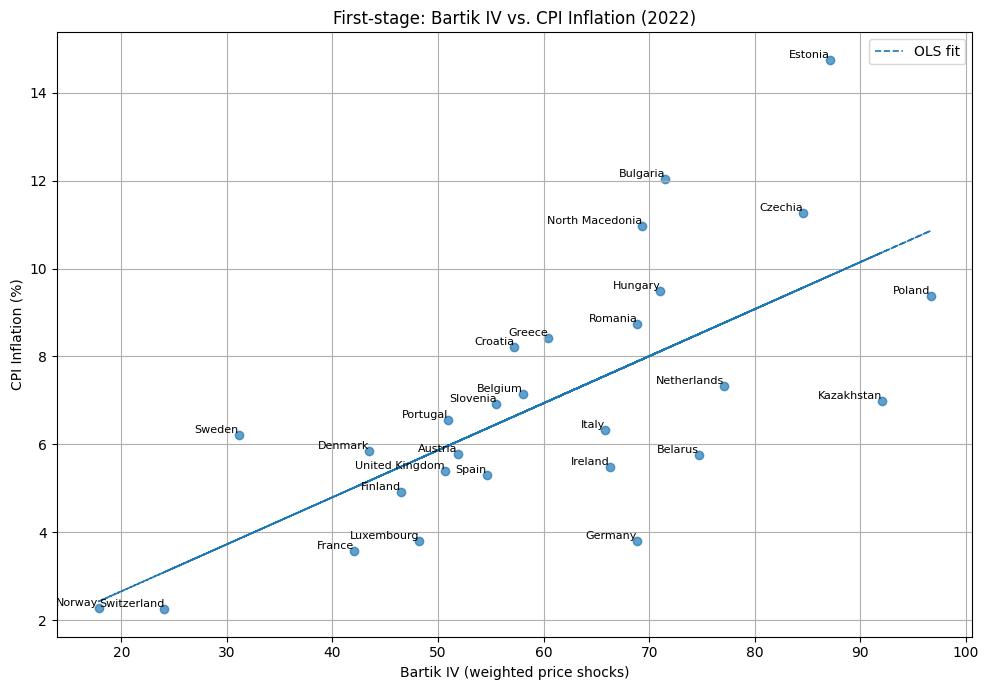

In [8]:
europe_or_nearby = [
    "Austria", "Belarus", "Belgium", "Bulgaria", "Croatia", "Czechia",
    "Denmark", "Finland", "France", "Germany", "Greece",
    "Hungary", "Ireland", "Italy", "Kazakhstan",
    "Luxembourg", "Netherlands", "North Macedonia", "Norway", "Poland",
    "Portugal", "Romania", "Slovakia", "Slovenia", "Spain", "Sweden",
    "Switzerland", "United Kingdom", "Estonia"
]

# outtliers: "Latvia", "Lithuania", "Estonia"

# Load 2021 inflation data alongside 2022
wb = pd.read_csv('../Design/data/world_inflation.csv', skiprows=4)
wb_diff = wb[['Country Name', '2021', '2022']].rename(
    columns={'2021': 'inflation_2021', '2022': 'inflation_2022'}
)

# Drop rows with missing data and convert to numeric
wb_diff = wb_diff.dropna(subset=['inflation_2021', 'inflation_2022'])
wb_diff['inflation_2021'] = pd.to_numeric(wb_diff['inflation_2021'], errors='coerce')
wb_diff['inflation_2022'] = pd.to_numeric(wb_diff['inflation_2022'], errors='coerce')

# Calculate inflation change
wb_diff['inflation_change'] = wb_diff['inflation_2022'] - wb_diff['inflation_2021']

# Merge with Bartik IV
merged_diff = bartik.merge(wb_diff[['Country Name', 'inflation_change']],
                           left_on='country', right_on='Country Name', how='left')

# Keep only relevant countries and drop missing
merged_diff = merged_diff[merged_diff['country'].isin(europe_or_nearby)]
merged_diff = merged_diff.dropna(subset=['inflation_change'])

# Optional: remove extreme outliers (e.g., >30% change)
merged_diff = merged_diff[merged_diff['inflation_change'].abs() <= 30]


# ---------- 7. Plot: Bartik IV vs. CPI Inflation ----------
x = merged_diff['bartik_iv'].values
y = merged_diff['inflation_change'].values
names = merged_diff['country'].values

# Fit OLS regression
m, b = np.polyfit(x, y, 1)

plt.figure(figsize=(10, 7))
plt.scatter(x, y, alpha=0.7)

# Annotate each point with country name
for i, name in enumerate(names):
    plt.text(x[i], y[i], name, fontsize=8, ha='right', va='bottom')

# Plot regression line
plt.plot(x, m * x + b, linestyle='--', linewidth=1.2, label='OLS fit')

plt.title("First-stage: Bartik IV vs. CPI Inflation (2022)")
plt.xlabel("Bartik IV (weighted price shocks)")
plt.ylabel("CPI Inflation (%)")
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

In [9]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Prepare data for regression
reg_df = merged_diff[['inflation_change', 'bartik_iv']].dropna()
X = sm.add_constant(reg_df['bartik_iv'])  # adds intercept term
y = reg_df['inflation_change']

# Fit OLS model (first-stage)
model = sm.OLS(y, X).fit()

# Print regression summary and F-statistic
print(model.summary())
print(f"\nFirst-stage F-statistic: {model.fvalue:.2f}, p-value: {model.f_pvalue:.4f}")


                            OLS Regression Results                            
Dep. Variable:       inflation_change   R-squared:                       0.487
Model:                            OLS   Adj. R-squared:                  0.468
Method:                 Least Squares   F-statistic:                     24.72
Date:                Mon, 05 May 2025   Prob (F-statistic):           3.62e-05
Time:                        14:40:06   Log-Likelihood:                -59.996
No. Observations:                  28   AIC:                             124.0
Df Residuals:                      26   BIC:                             126.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5243      1.357      0.386      0.7

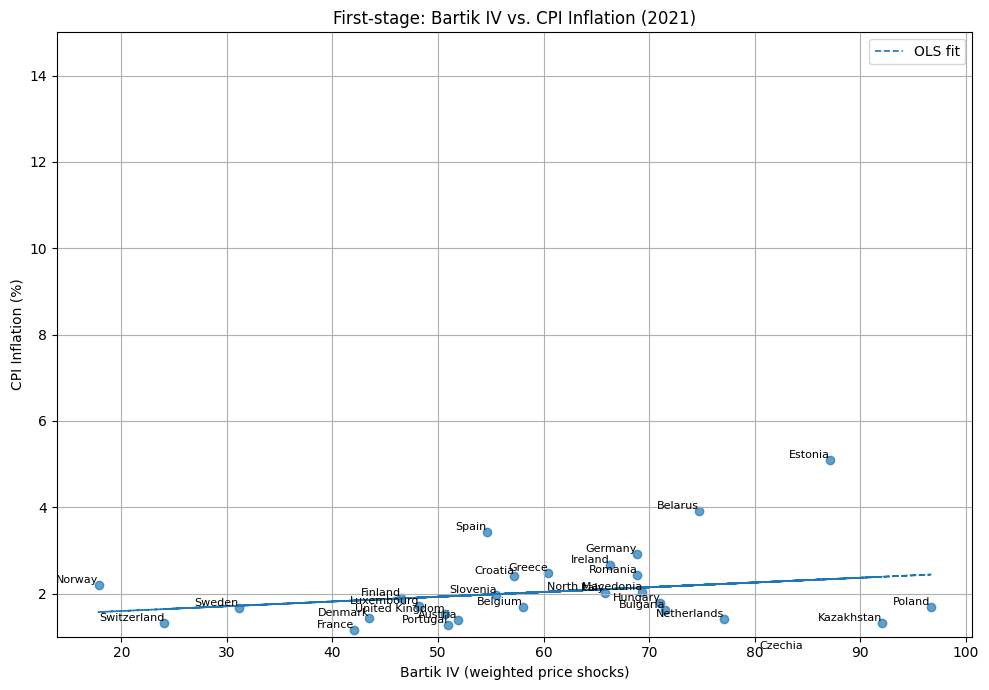

In [10]:
europe_or_nearby = [
    "Austria", "Belarus", "Belgium", "Bulgaria", "Croatia", "Czechia",
    "Denmark", "Finland", "France", "Germany", "Greece",
    "Hungary", "Ireland", "Italy", "Kazakhstan",
    "Luxembourg", "Netherlands", "North Macedonia", "Norway", "Poland",
    "Portugal", "Romania", "Slovakia", "Slovenia", "Spain", "Sweden",
    "Switzerland", "United Kingdom", "Estonia"
]

# outtliers: "Latvia", "Lithuania", "Estonia"

# Load 2020 inflation data alongside 2021
wb = pd.read_csv('../Design/data/world_inflation.csv', skiprows=4)
wb_diff = wb[['Country Name', '2020', '2021']].rename(
    columns={'2020': 'inflation_2020', '2021': 'inflation_2021'}
)

# Drop rows with missing data and convert to numeric
wb_diff = wb_diff.dropna(subset=['inflation_2020', 'inflation_2021'])
wb_diff['inflation_2020'] = pd.to_numeric(wb_diff['inflation_2020'], errors='coerce')
wb_diff['inflation_2021'] = pd.to_numeric(wb_diff['inflation_2021'], errors='coerce')

# Calculate inflation change
wb_diff['inflation_change'] = wb_diff['inflation_2021'] - wb_diff['inflation_2020']

# Merge with Bartik IV
merged_diff = bartik.merge(wb_diff[['Country Name', 'inflation_change']],
                           left_on='country', right_on='Country Name', how='left')

# Keep only relevant countries and drop missing
merged_diff = merged_diff[merged_diff['country'].isin(europe_or_nearby)]
merged_diff = merged_diff.dropna(subset=['inflation_change'])

# Optional: remove extreme outliers (e.g., >30% change)
merged_diff = merged_diff[merged_diff['inflation_change'].abs() <= 30]


# ---------- 7. Plot: Bartik IV vs. CPI Inflation ----------
x = merged_diff['bartik_iv'].values
y = merged_diff['inflation_change'].values
names = merged_diff['country'].values

# Fit OLS regression
m, b = np.polyfit(x, y, 1)

plt.figure(figsize=(10, 7))
plt.scatter(x, y, alpha=0.7)
# keep y axis height the same
plt.ylim(1, 15)

# Annotate each point with country name
for i, name in enumerate(names):
    plt.text(x[i], y[i], name, fontsize=8, ha='right', va='bottom')

# Plot regression line
plt.plot(x, m * x + b, linestyle='--', linewidth=1.2, label='OLS fit')

plt.title("First-stage: Bartik IV vs. CPI Inflation (2021)")
plt.xlabel("Bartik IV (weighted price shocks)")
plt.ylabel("CPI Inflation (%)")
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

In [11]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Prepare data for regression
reg_df = merged_diff[['inflation_change', 'bartik_iv']].dropna()
X = sm.add_constant(reg_df['bartik_iv'])  # adds intercept term
y = reg_df['inflation_change']

# Fit OLS model (first-stage)
model = sm.OLS(y, X).fit()

# Print regression summary and F-statistic
print(model.summary())
print(f"\nFirst-stage F-statistic: {model.fvalue:.2f}, p-value: {model.f_pvalue:.4f}")


                            OLS Regression Results                            
Dep. Variable:       inflation_change   R-squared:                       0.053
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     1.441
Date:                Mon, 05 May 2025   Prob (F-statistic):              0.241
Time:                        14:40:06   Log-Likelihood:                -36.145
No. Observations:                  28   AIC:                             76.29
Df Residuals:                      26   BIC:                             78.95
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.3757      0.579      2.377      0.0

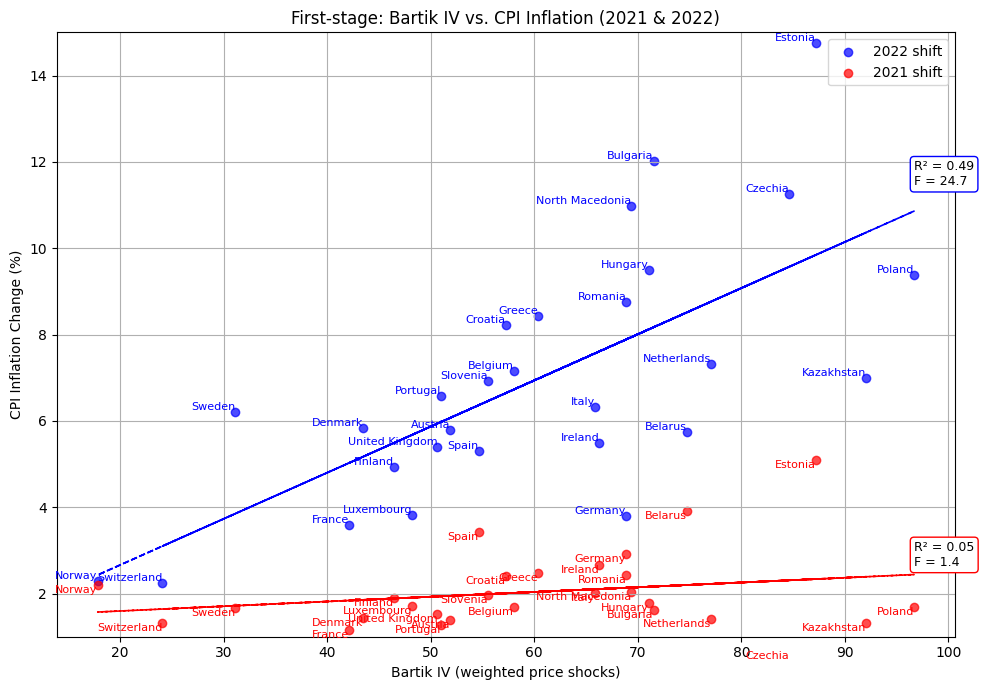

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Load inflation data
wb = pd.read_csv('../Design/data/world_inflation.csv', skiprows=4)

# Define function for inflation change and regression
def compute_inflation_shift(year1, year2, color, label, y_offset):
    wb_diff = wb[['Country Name', year1, year2]].rename(
        columns={year1: f'inflation_{year1}', year2: f'inflation_{year2}'}
    )
    wb_diff = wb_diff.dropna()
    wb_diff[f'inflation_{year1}'] = pd.to_numeric(wb_diff[f'inflation_{year1}'], errors='coerce')
    wb_diff[f'inflation_{year2}'] = pd.to_numeric(wb_diff[f'inflation_{year2}'], errors='coerce')
    wb_diff['inflation_change'] = wb_diff[f'inflation_{year2}'] - wb_diff[f'inflation_{year1}']

    merged = bartik.merge(wb_diff[['Country Name', 'inflation_change']],
                          left_on='country', right_on='Country Name', how='left')
    merged = merged[merged['country'].isin(europe_or_nearby)]
    merged = merged.dropna(subset=['inflation_change'])
    merged = merged[merged['inflation_change'].abs() <= 30]

    x = merged['bartik_iv'].values
    y = merged['inflation_change'].values
    names = merged['country'].values

    # Plot points
    plt.scatter(x, y, alpha=0.7, label=label, color=color)

    # OLS with statsmodels
    X_ols = sm.add_constant(x)
    model = sm.OLS(y, X_ols).fit()
    y_pred = model.predict(X_ols)

    # Plot regression line
    plt.plot(x, y_pred, linestyle='--', linewidth=1.2, color=color)

    # Add stats box
    r2 = model.rsquared
    fstat = model.fvalue
    textstr = f'R² = {r2:.2f}\nF = {fstat:.1f}'
    plt.text(max(x), max(y_pred) + y_offset, textstr,
             fontsize=9, bbox=dict(facecolor='white', edgecolor=color, boxstyle='round,pad=0.3'))

    return x, y, names

# Start plot
plt.figure(figsize=(10, 7))

# 2022 in blue
x_2022, y_2022, names_2022 = compute_inflation_shift('2021', '2022', 'blue', '2022 shift', y_offset=0.6)

# 2021 in red
x_2021, y_2021, names_2021 = compute_inflation_shift('2020', '2021', 'red', '2021 shift', y_offset=0.2)

# Annotate points
for i, name in enumerate(names_2022):
    plt.text(x_2022[i], y_2022[i], name, fontsize=8, ha='right', va='bottom', color='blue')

for i, name in enumerate(names_2021):
    plt.text(x_2021[i], y_2021[i], name, fontsize=8, ha='right', va='top', color='red')

plt.title("First-stage: Bartik IV vs. CPI Inflation (2021 & 2022)")
plt.xlabel("Bartik IV (weighted price shocks)")
plt.ylabel("CPI Inflation Change (%)")
plt.ylim(1, 15)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
